In [1]:
import pandas as pd
from scipy.io import arff as arf
from sklearn import tree
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

In [2]:
unalteredData = pd.read_csv('../data/kidney_disease.csv', sep=',',na_values=['?'], low_memory=False)

In [3]:
unalteredData.dropna(subset=['classification'],inplace=True)
data = unalteredData
header = data['classification']

In [4]:
data.isnull().sum()

id                           0
age                          9
blood pressure               9
specific gravity            44
albumin                     43
sugar                       45
red blood cells            142
pus cell                    61
pus cell clumps              4
bacteria                     4
blood glucose random        42
blood urea                  18
serum creatinine            16
sodium                      81
potassium                   82
hemoglobin                  47
packed cell volume          65
white blood cell count      99
red blood cell count       122
hypertension                 2
diabetes mellitus            2
coronary artery disease      2
appetite                     1
pedal edema                  1
anemia                       1
classification               0
dtype: int64

# Data preparation methods

In [5]:
data.head(10)

,id,age,blood pressure,specific gravity,albumin,sugar,red blood cells,pus cell,pus cell clumps,bacteria,...,packed cell volume,white blood cell count,red blood cell count,hypertension,diabetes mellitus,coronary artery disease,appetite,pedal edema,anemia,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd
5,5,60.0,90.0,1.015,3.0,0.0,NaN,NaN,notpresent,notpresent,...,39.0,7800.0,4.4,yes,yes,no,good,yes,no,ckd
6,6,68.0,70.0,1.010,0.0,0.0,NaN,normal,notpresent,notpresent,...,36.0,NaN,NaN,no,no,no,good,no,no,ckd
7,7,24.0,NaN,1.015,2.0,4.0,normal,abnormal,notpresent,notpresent,...,44.0,6900.0,5.0,no,yes,no,good,yes,no,ckd
8,8,52.0,100.0,1.015,3.0,0.0,normal,abnormal,present,notpresent,...,33.0,9600.0,4.0,yes,yes,no,good,no,yes,ckd
9,9,53.0,90.0,1.020,2.0,0.0,abnormal,abnormal,present,notpresent,...,29.0,12100.0,3.7,yes,yes,no,poor,no,yes,ckd


In [6]:
data.isnull().sum()

id                           0
age                          9
blood pressure               9
specific gravity            44
albumin                     43
sugar                       45
red blood cells            142
pus cell                    61
pus cell clumps              4
bacteria                     4
blood glucose random        42
blood urea                  18
serum creatinine            16
sodium                      81
potassium                   82
hemoglobin                  47
packed cell volume          65
white blood cell count      99
red blood cell count       122
hypertension                 2
diabetes mellitus            2
coronary artery disease      2
appetite                     1
pedal edema                  1
anemia                       1
classification               0
dtype: int64

In [7]:
data = data.drop(['red blood cells'], axis=1)
data = data.drop(['id'], axis=1)

In [8]:
def yesno_to_numeric(x):
        if x=='yes': return 1
        if x=='no':   return 0

def normal_to_numeric(x):
        if x=='normal': return 1
        if x=='abnormal':   return 0

def present_to_numeric(x):
        if x=='notpresent': return 1
        if x=='present':   return 0
        
def good_to_numeric(x):
        if x=='good': return 1
        if x=='poor':   return 0
        
def ckd_to_numeric(x):
        if x=='ckd': return 1
        if x=='notckd':   return 0
        
        
        

In [9]:
data['hypertension'] = data['hypertension'].apply(yesno_to_numeric)
data['diabetes mellitus'] = data['diabetes mellitus'].apply(yesno_to_numeric)
data['coronary artery disease'] = data['coronary artery disease'].apply(yesno_to_numeric)
data['pedal edema '] = data['pedal edema '].apply(yesno_to_numeric)
data['anemia '] = data['anemia '].apply(yesno_to_numeric)
data['pus cell'] = data['pus cell'].apply(normal_to_numeric)
data['pus cell clumps'] = data['pus cell clumps'].apply(present_to_numeric)
data['bacteria '] = data['bacteria '].apply(present_to_numeric)
data['appetite'] = data['appetite'].apply(good_to_numeric)
data['classification'] = data['classification'].apply(ckd_to_numeric)


In [10]:
data.head(10)
data.dtypes

age                        float64
blood pressure             float64
specific gravity           float64
albumin                    float64
sugar                      float64
pus cell                   float64
pus cell clumps            float64
bacteria                   float64
blood glucose random       float64
blood urea                 float64
serum creatinine           float64
sodium                     float64
potassium                  float64
hemoglobin                 float64
packed cell volume         float64
white blood cell count     float64
red blood cell count       float64
hypertension               float64
diabetes mellitus          float64
coronary artery disease    float64
appetite                   float64
pedal edema                float64
anemia                     float64
classification               int64
dtype: object

In [11]:
def fill_with_mean(data):
    for i in range(data.shape[1]):
        mean_value = data[list(data)[i]].mean()
        data[list(data)[i]] = data[list(data)[i]].fillna(mean_value)

In [12]:
fill_with_mean(data)

In [13]:
data.isnull().sum()

age                        0
blood pressure             0
specific gravity           0
albumin                    0
sugar                      0
pus cell                   0
pus cell clumps            0
bacteria                   0
blood glucose random       0
blood urea                 0
serum creatinine           0
sodium                     0
potassium                  0
hemoglobin                 0
packed cell volume         0
white blood cell count     0
red blood cell count       0
hypertension               0
diabetes mellitus          0
coronary artery disease    0
appetite                   0
pedal edema                0
anemia                     0
classification             0
dtype: int64

# Visual Reprensentation

In [14]:
data.describe()

,age,blood pressure,specific gravity,albumin,sugar,pus cell,pus cell clumps,bacteria,blood glucose random,blood urea,...,packed cell volume,white blood cell count,red blood cell count,hypertension,diabetes mellitus,coronary artery disease,appetite,pedal edema,anemia,classification
count,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,...,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000
mean,51.364362,76.303191,1.017595,0.985380,0.464706,0.780864,0.892388,0.944882,148.180758,57.420163,...,38.937500,8416.783217,4.706464,0.365535,0.335079,0.088773,0.791667,0.192708,0.153646,0.610390
std,16.760808,13.497824,0.005335,1.263394,1.046543,0.379972,0.308676,0.227317,75.720064,49.782878,...,8.260528,2546.637612,0.830598,0.480952,0.470787,0.284045,0.406116,0.394426,0.360609,0.488296
min,2.000000,50.000000,1.005000,0.000000,0.000000,0.000000,0.000000,0.000000,22.000000,1.500000,...,9.000000,2200.000000,2.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,42.000000,70.000000,1.015000,0.000000,0.000000,0.780864,1.000000,1.000000,101.000000,27.000000,...,34.000000,7000.000000,4.500000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,54.000000,76.303191,1.017595,0.000000,0.000000,1.000000,1.000000,1.000000,125.000000,44.000000,...,38.937500,8416.783217,4.706464,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,64.000000,80.000000,1.020000,2.000000,0.464706,1.000000,1.000000,1.000000,150.000000,60.000000,...,44.000000,9400.000000,5.100000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,90.000000,180.000000,1.025000,5.000000,5.000000,1.000000,1.000000,1.000000,490.000000,391.000000,...,54.000000,26400.000000,6.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
len(data)

385

In [16]:
corrmat = data.corr()
corrmat

,age,blood pressure,specific gravity,albumin,sugar,pus cell,pus cell clumps,bacteria,blood glucose random,blood urea,...,packed cell volume,white blood cell count,red blood cell count,hypertension,diabetes mellitus,coronary artery disease,appetite,pedal edema,anemia,classification
age,1.000000,0.155226,-0.172668,0.108627,0.217984,-0.129137,-0.159756,-0.048497,0.210902,0.192487,...,-0.220678,0.108020,-0.219536,0.389957,0.356943,0.243507,-0.157677,0.099394,0.048354,0.229827
blood pressure,0.155226,1.000000,-0.173158,0.128017,0.211325,-0.186834,-0.074040,-0.115462,0.150198,0.180041,...,-0.298635,0.016161,-0.245840,0.269529,0.242776,0.090803,-0.194137,0.061454,0.202351,0.289567
specific gravity,-0.172668,-0.173158,1.000000,-0.461482,-0.308094,0.350174,0.301066,0.212538,-0.335318,-0.280124,...,0.543426,-0.207067,0.490646,-0.370347,-0.393574,-0.165266,0.262502,-0.284974,-0.232052,-0.698483
albumin,0.108627,0.128017,-0.461482,1.000000,0.285033,-0.564744,-0.415188,-0.363522,0.333147,0.401029,...,-0.536736,0.197937,-0.497207,0.475176,0.375729,0.248219,-0.349138,0.447950,0.300128,0.603140
sugar,0.217984,0.211325,-0.308094,0.285033,1.000000,-0.199435,-0.151127,-0.110984,0.644929,0.155227,...,-0.205288,0.155521,-0.185665,0.302523,0.489876,0.243847,-0.078231,0.132662,0.062220,0.343380
pus cell,-0.129137,-0.186834,0.350174,-0.564744,-0.199435,1.000000,0.514309,0.319017,-0.285196,-0.393183,...,0.465334,-0.127206,0.426466,-0.345831,-0.249387,-0.199387,0.295183,-0.386581,-0.306089,-0.433677
pus cell clumps,-0.159756,-0.074040,0.301066,-0.415188,-0.151127,0.514309,1.000000,0.287265,-0.194079,-0.193399,...,0.298444,-0.161769,0.274884,-0.190424,-0.163388,-0.187776,0.173848,-0.107290,-0.178609,-0.271452
bacteria,-0.048497,-0.115462,0.212538,-0.363522,-0.110984,0.319017,0.287265,1.000000,-0.089023,-0.143445,...,0.190220,-0.115591,0.189487,-0.101070,-0.070312,-0.166014,0.157379,-0.113584,-0.055264,-0.188799
blood glucose random,0.210902,0.150198,-0.335318,0.333147,0.644929,-0.285196,-0.194079,-0.089023,1.000000,0.134608,...,-0.274378,0.118928,-0.230161,0.372562,0.502481,0.212611,-0.175555,0.103436,0.128909,0.410343
blood urea,0.192487,0.180041,-0.280124,0.401029,0.155227,-0.393183,-0.193399,-0.143445,0.134608,1.000000,...,-0.528352,0.044360,-0.492542,0.394919,0.317776,0.225403,-0.283594,0.335903,0.442860,0.379825


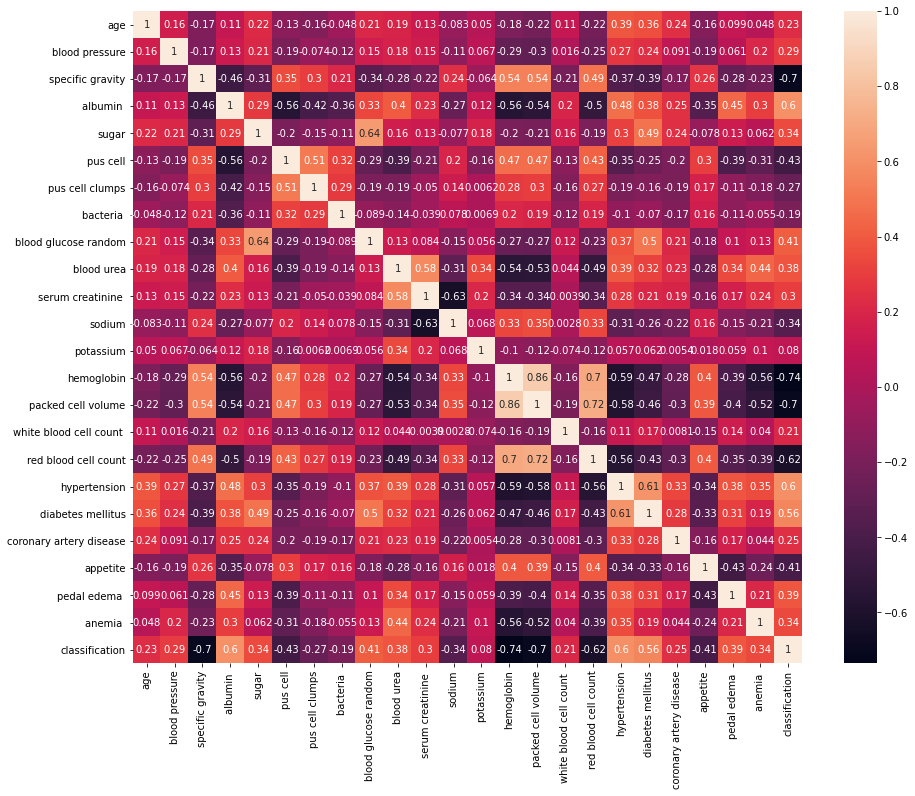

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 12))
sns.heatmap(corrmat, annot=True)
plt.show()

In [18]:
kidneyDisease = unalteredData.groupby('classification').mean()
kidneyDisease

,age,blood pressure,specific gravity,albumin,sugar,blood glucose random,blood urea,serum creatinine,sodium,potassium,hemoglobin,packed cell volume,white blood cell count,red blood cell count
classification,,,,,,,,,,,,,,
ckd,54.546256,79.517544,1.014031,1.71066,0.810256,177.457286,73.319283,4.537723,133.833333,4.904430,10.600515,32.729885,9127.972028,3.905000
notckd,46.516779,71.351351,1.022414,0.00000,0.000000,107.722222,32.798611,0.868966,141.731034,4.337931,15.188194,46.335616,7705.594406,5.379021


<AxesSubplot:xlabel='classification'>

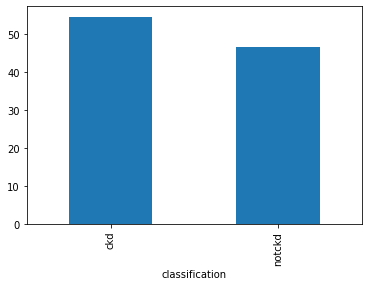

In [19]:
kidneyDisease['age'].plot.bar()

In [20]:
sugar = data.groupby('sugar').mean()
sugar

,age,blood pressure,specific gravity,albumin,pus cell,pus cell clumps,bacteria,blood glucose random,blood urea,serum creatinine,...,packed cell volume,white blood cell count,red blood cell count,hypertension,diabetes mellitus,coronary artery disease,appetite,pedal edema,anemia,classification
sugar,,,,,,,,,,,,,,,,,,,,,
0.000000,48.325526,74.423378,1.018530,0.741935,0.822116,0.908851,0.956199,124.091769,49.055134,2.138871,...,40.397177,8201.037672,4.838921,0.235595,0.170861,0.032894,0.837963,0.144060,0.111662,0.480287
0.464706,57.490957,79.028960,1.017422,1.052697,0.795473,1.000000,1.000000,152.997862,82.611559,7.094444,...,36.038889,8121.554002,4.470832,0.711111,0.651891,0.177778,0.711111,0.311111,0.311111,0.888889
1.000000,61.307692,80.000000,1.013462,2.538462,0.538462,0.615385,0.769231,213.615385,92.200000,4.276923,...,33.225962,10034.642281,4.093799,0.769231,0.769231,0.230769,0.307692,0.384615,0.307692,1.000000
2.000000,63.742465,83.888889,1.013611,2.222222,0.673525,0.777778,0.833333,237.863460,70.681138,4.410674,...,32.937500,10054.662005,4.202514,0.777778,0.833333,0.388889,0.611111,0.333333,0.277778,1.000000
3.000000,62.000000,84.285714,1.013043,1.928571,0.484347,0.785714,0.857143,251.740108,84.285714,5.557143,...,34.906250,9228.621379,4.217518,0.571429,0.857143,0.357143,0.785714,0.285714,0.285714,1.000000
4.000000,54.230769,83.561784,1.013661,1.538462,0.521605,0.692308,1.000000,290.552366,68.615385,4.446154,...,36.682692,8935.933297,4.556332,0.615385,0.923077,0.153846,0.769231,0.384615,0.076923,1.000000
5.000000,62.666667,80.000000,1.013333,1.666667,0.926955,1.000000,0.666667,394.333333,53.333333,1.800000,...,36.000000,10033.333333,4.533333,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000


<AxesSubplot:xlabel='classification'>

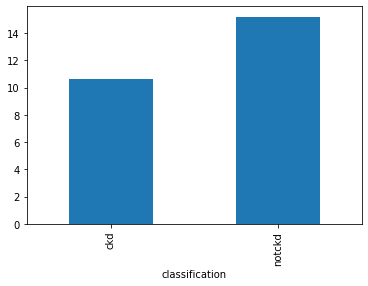

In [21]:
hemoglobin = unalteredData.groupby('classification').mean()
hemoglobin
hemoglobin['hemoglobin'].plot.bar()

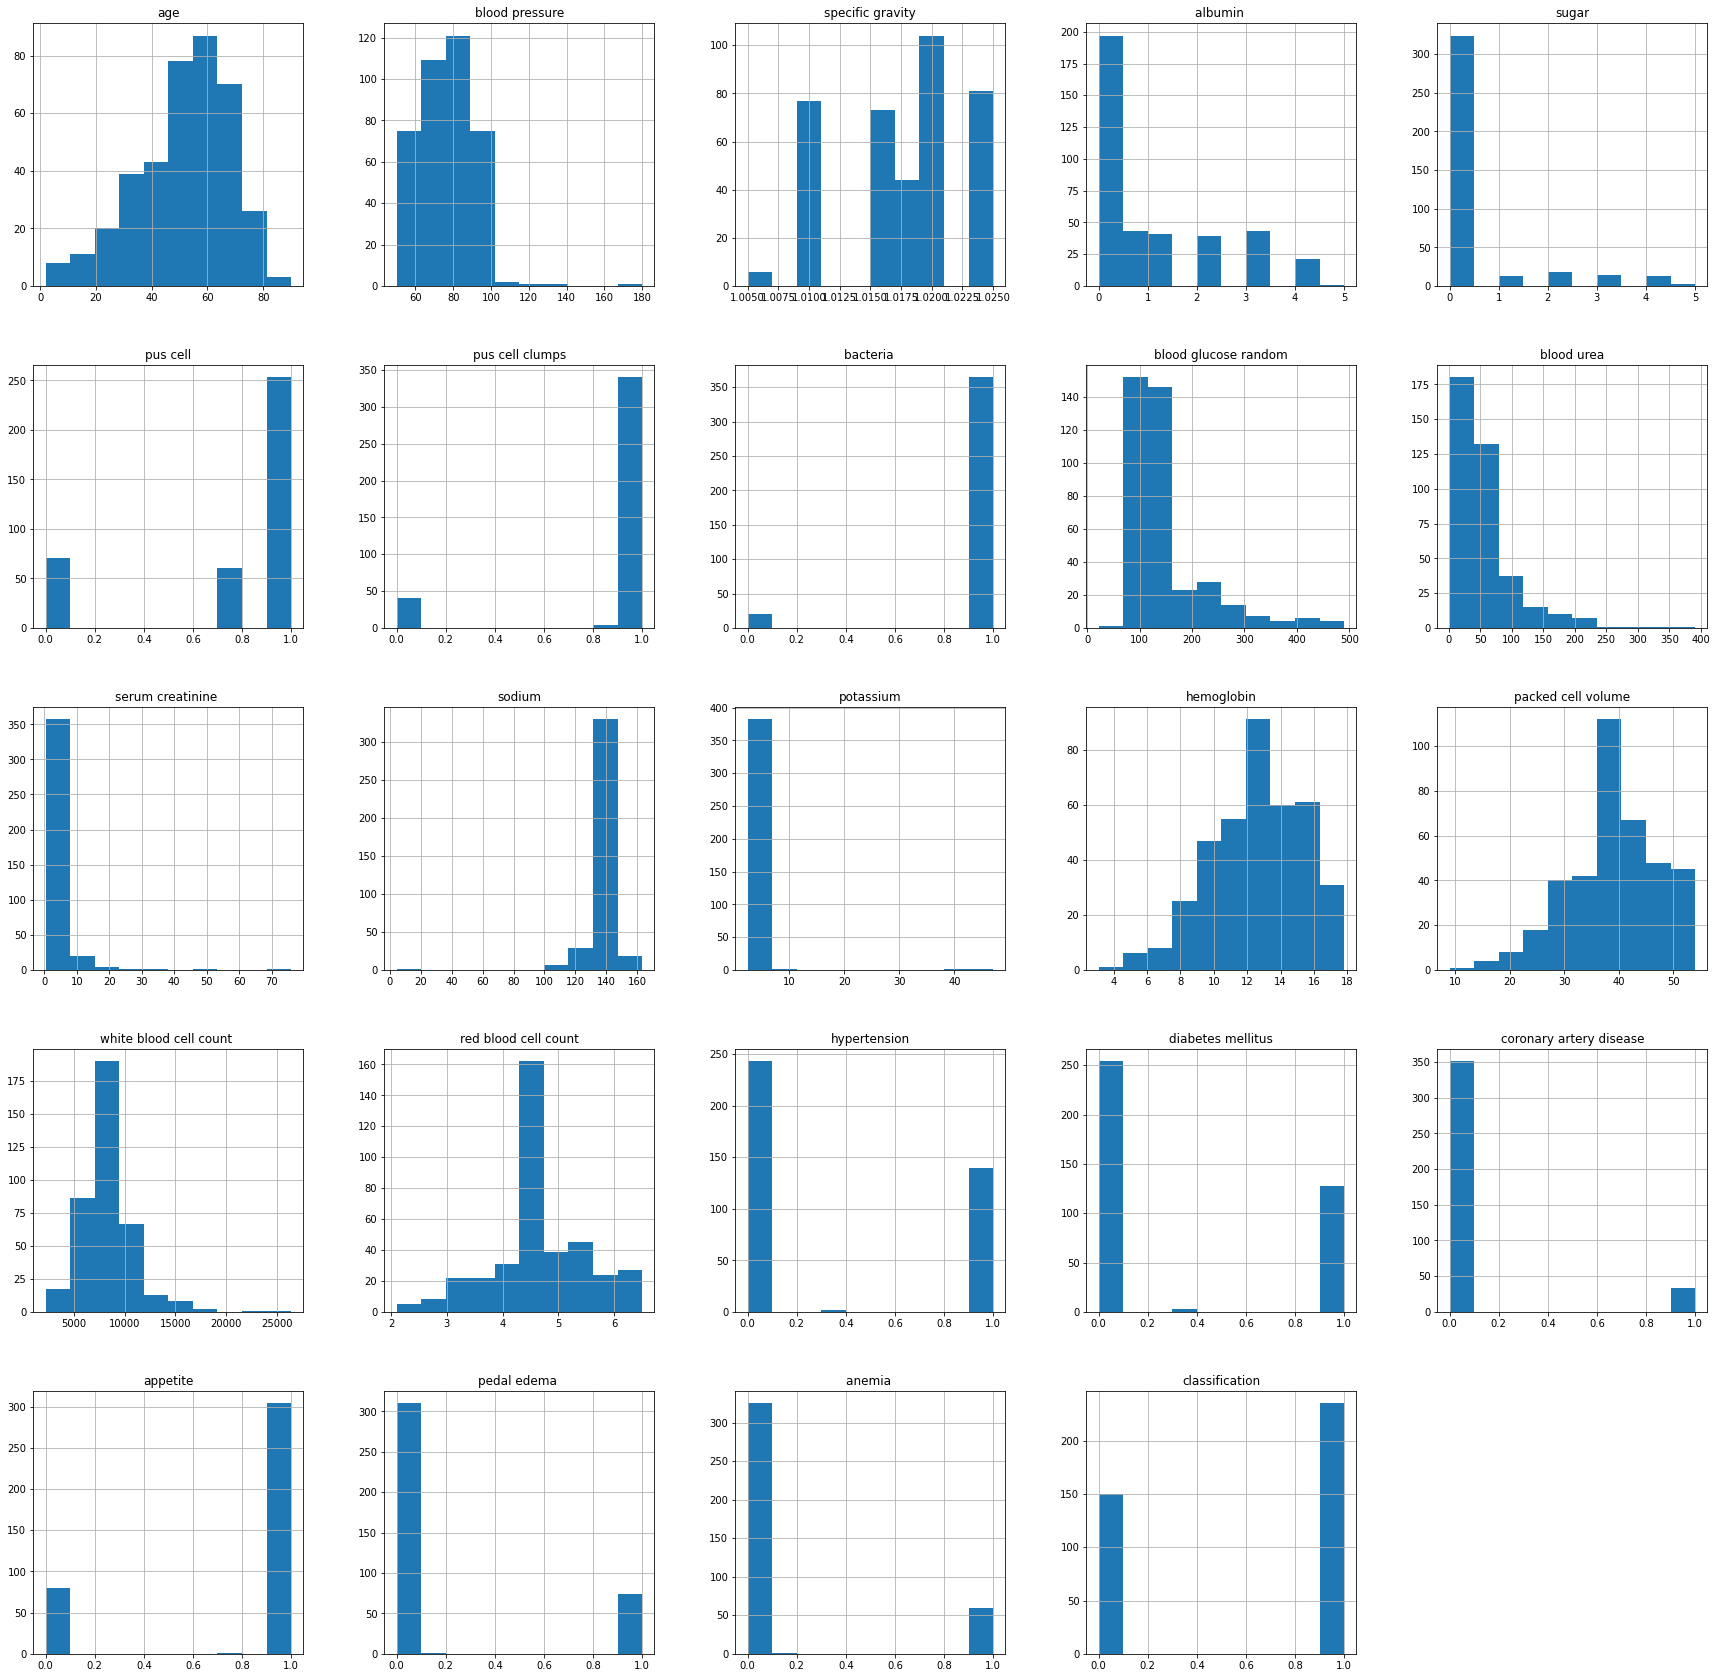

In [22]:
data.hist(figsize=(30,30))
plt.show()

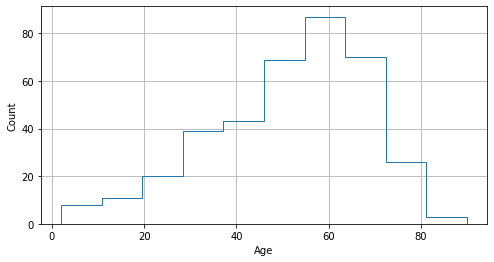

In [23]:
histogramAge = unalteredData['age'].hist(figsize=(8,4),histtype = 'step')
histogramAge.set_xlabel("Age")
histogramAge.set_ylabel("Count")
plt.show()

In [24]:
newData = data[['age', 'classification']].copy()
newData.head()

,age,classification
0,48.0,1
1,7.0,1
2,62.0,1
3,48.0,1
4,51.0,1


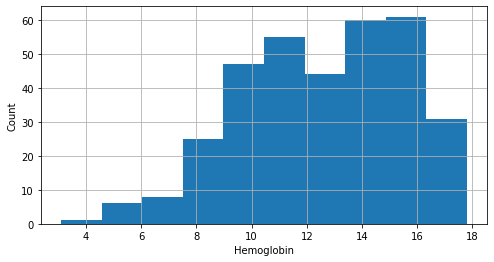

In [25]:
histogramHemo = unalteredData['hemoglobin'].hist(figsize=(8,4))
histogramHemo.set_xlabel("Hemoglobin")
histogramHemo.set_ylabel("Count")
plt.show()

Drop the classification header before training

In [26]:
y = data[['classification']]
X = data.drop(['classification'], axis=1)
y = y.values[:,0]

In [27]:
set_prop = 0.3

#  Initialize seed parameter for the random number generator used for the split
seed = 7

# Split
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=set_prop, random_state=seed)

## Test model with KNN 

In [28]:
success_rate = []
for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    success_rate.append(accuracy_score(y_test, pred_i))
print(success_rate)
print(max(success_rate))
success_rate.index(max(success_rate))

[0.7068965517241379, 0.7586206896551724, 0.6896551724137931, 0.7413793103448276, 0.75, 0.7586206896551724, 0.75, 0.7327586206896551, 0.7672413793103449, 0.7327586206896551, 0.75, 0.7327586206896551, 0.7241379310344828, 0.7155172413793104, 0.7413793103448276, 0.7241379310344828, 0.7155172413793104, 0.7068965517241379, 0.7068965517241379, 0.6982758620689655, 0.7327586206896551, 0.7413793103448276, 0.6810344827586207, 0.6896551724137931, 0.6810344827586207, 0.6982758620689655, 0.6810344827586207, 0.6896551724137931, 0.6896551724137931, 0.6982758620689655, 0.6810344827586207, 0.6810344827586207, 0.6810344827586207, 0.6896551724137931, 0.6637931034482759, 0.6810344827586207, 0.6637931034482759, 0.6724137931034483, 0.6810344827586207]
0.7672413793103449


8

## Test model with Gaussian Naive Bayes

In [29]:
gaussianClassifierNB = GaussianNB()
gaussianClassifierNB.fit(X_train, y_train)
predict_y = gaussianClassifierNB.predict(X_test)
accuracy = accuracy_score(y_test, predict_y)
print(accuracy)

0.9827586206896551


## Test model with Multinominal Naive Bayes

In [30]:
multiClassifierNB = MultinomialNB()
multiClassifierNB.fit(X_train, y_train)
predict_y = multiClassifierNB.predict(X_test)
accuracy = accuracy_score(y_test, predict_y)
print(accuracy)

0.8362068965517241


## Test model with Decision Tree

In [31]:
success_rate = []
for i in range(1,40):
    params = {'max_depth': i}
    dtc = DecisionTreeClassifier(**params)
    dtc.fit(X_train,y_train)
    pred_i = dtc.predict(X_test)
    success_rate.append(accuracy_score(y_test, pred_i))
print(success_rate)
print(max(success_rate))
success_rate.index(max(success_rate))+1

[0.8793103448275862, 0.9741379310344828, 0.9741379310344828, 0.9741379310344828, 0.9655172413793104, 0.9655172413793104, 0.9655172413793104, 0.9655172413793104, 0.9827586206896551, 0.9655172413793104, 0.9655172413793104, 0.9741379310344828, 0.9568965517241379, 0.9568965517241379, 0.9741379310344828, 0.9827586206896551, 0.9655172413793104, 0.9741379310344828, 0.9827586206896551, 0.9827586206896551, 0.9655172413793104, 0.9655172413793104, 0.9655172413793104, 0.9827586206896551, 0.9482758620689655, 0.9655172413793104, 0.9741379310344828, 0.9655172413793104, 0.9655172413793104, 0.9655172413793104, 0.9913793103448276, 0.9655172413793104, 0.9655172413793104, 0.9741379310344828, 0.9655172413793104, 0.9827586206896551, 0.9741379310344828, 0.9655172413793104, 0.9655172413793104]
0.9913793103448276


31

## Part 2
In this part we want to process the data for removing removing outliers and entries of freak entries.

In [32]:
factor = 3
upper_lim = data['specific gravity'].mean () + data['specific gravity'].std () * factor
lower_lim = data['specific gravity'].mean () - data['specific gravity'].std () * factor
data = data[(data['specific gravity'] < upper_lim) & (data['specific gravity'] > lower_lim)]
upper_lim = data['hemoglobin'].mean () + data['hemoglobin'].std () * factor
lower_lim = data['hemoglobin'].mean () - data['hemoglobin'].std () * factor
data = data[(data['hemoglobin'] < upper_lim) & (data['hemoglobin'] > lower_lim)]
upper_lim = data['packed cell volume'].mean () + data['packed cell volume'].std () * factor
lower_lim = data['packed cell volume'].mean () - data['packed cell volume'].std () * factor
data = data[(data['packed cell volume'] < upper_lim) & (data['packed cell volume'] > lower_lim)]
upper_lim = data['red blood cell count'].mean () + data['red blood cell count'].std () * factor
lower_lim = data['red blood cell count'].mean () - data['red blood cell count'].std () * factor
data = data[(data['red blood cell count'] < upper_lim) & (data['red blood cell count'] > lower_lim)]
data

,age,blood pressure,specific gravity,albumin,sugar,pus cell,pus cell clumps,bacteria,blood glucose random,blood urea,...,packed cell volume,white blood cell count,red blood cell count,hypertension,diabetes mellitus,coronary artery disease,appetite,pedal edema,anemia,classification
0,48.0,80.0,1.020,1.0,0.0,1.0,1.0,1.0,121.000000,36.0,...,44.0,7800.0,5.200000,1.0,1.0,0.0,1.0,0.0,0.0,1
1,7.0,50.0,1.020,4.0,0.0,1.0,1.0,1.0,148.180758,18.0,...,38.0,6000.0,4.706464,0.0,0.0,0.0,1.0,0.0,0.0,1
2,62.0,80.0,1.010,2.0,3.0,1.0,1.0,1.0,423.000000,53.0,...,31.0,7500.0,4.706464,0.0,1.0,0.0,0.0,0.0,1.0,1
3,48.0,70.0,1.005,4.0,0.0,0.0,0.0,1.0,117.000000,56.0,...,32.0,6700.0,3.900000,1.0,0.0,0.0,0.0,1.0,1.0,1
4,51.0,80.0,1.010,2.0,0.0,1.0,1.0,1.0,106.000000,26.0,...,35.0,7300.0,4.600000,0.0,0.0,0.0,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,1.0,1.0,1.0,140.000000,49.0,...,47.0,6700.0,4.900000,0.0,0.0,0.0,1.0,0.0,0.0,0
396,42.0,70.0,1.025,0.0,0.0,1.0,1.0,1.0,75.000000,31.0,...,54.0,7800.0,6.200000,0.0,0.0,0.0,1.0,0.0,0.0,0
397,12.0,80.0,1.020,0.0,0.0,1.0,1.0,1.0,100.000000,26.0,...,49.0,6600.0,5.400000,0.0,0.0,0.0,1.0,0.0,0.0,0
398,17.0,60.0,1.025,0.0,0.0,1.0,1.0,1.0,114.000000,50.0,...,51.0,7200.0,5.900000,0.0,0.0,0.0,1.0,0.0,0.0,0


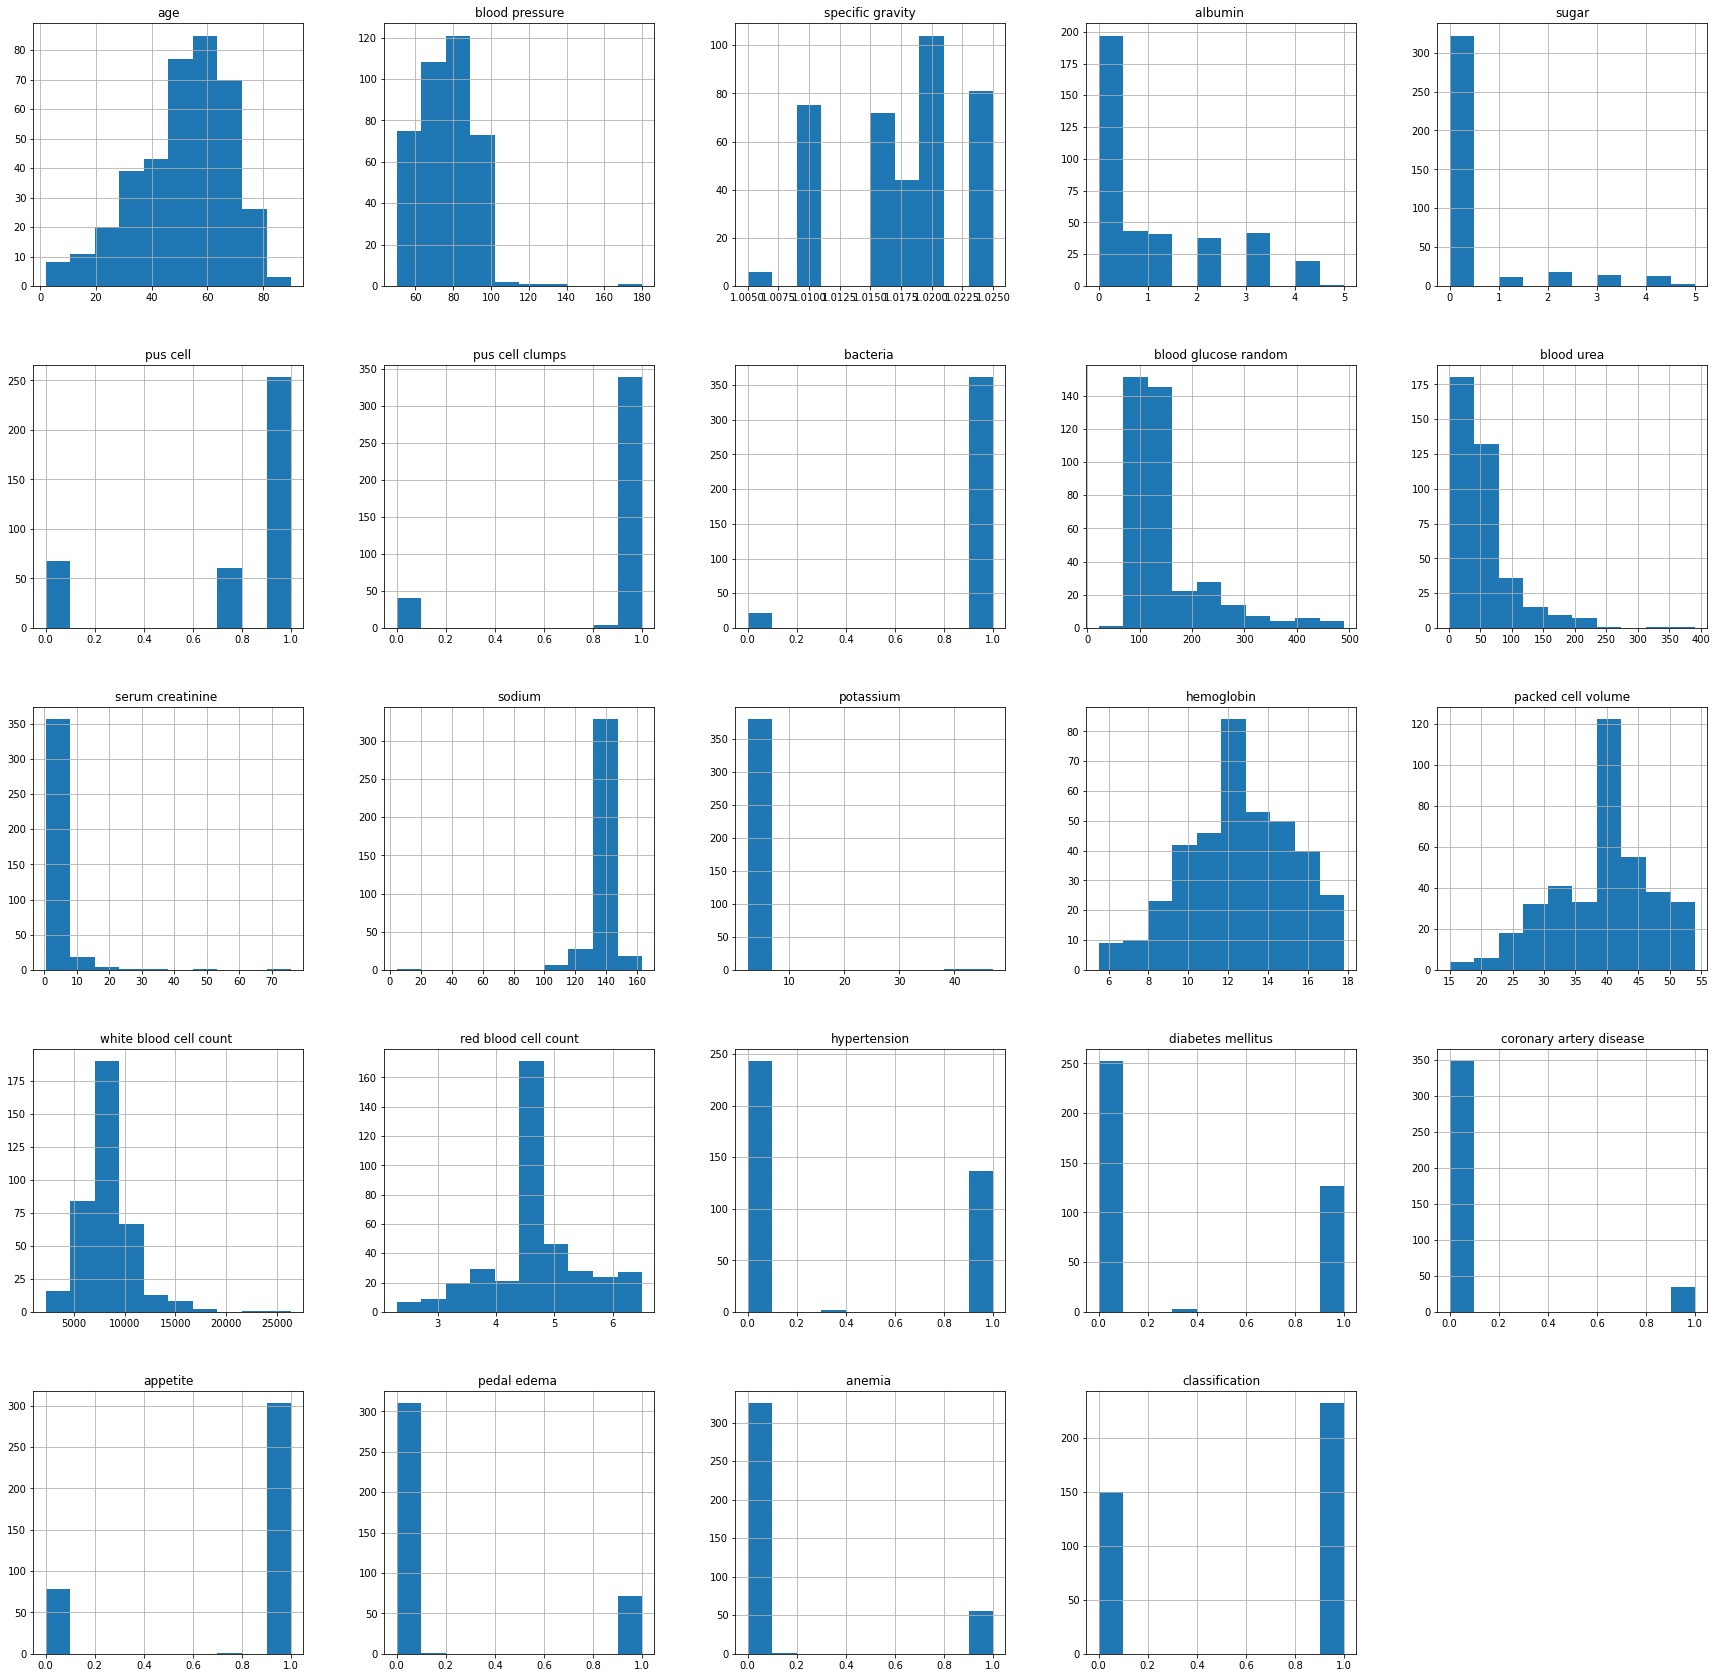

In [33]:
data.hist(figsize=(30,30))
plt.show()

In [34]:
data.isnull().sum()

age                        0
blood pressure             0
specific gravity           0
albumin                    0
sugar                      0
pus cell                   0
pus cell clumps            0
bacteria                   0
blood glucose random       0
blood urea                 0
serum creatinine           0
sodium                     0
potassium                  0
hemoglobin                 0
packed cell volume         0
white blood cell count     0
red blood cell count       0
hypertension               0
diabetes mellitus          0
coronary artery disease    0
appetite                   0
pedal edema                0
anemia                     0
classification             0
dtype: int64